In [147]:

import pandas as pd

X_train = pd.read_csv('../../data/representation.eng.train.csv').to_numpy()
y_train = pd.read_csv('../../data/true_labels.eng.train.csv')

X_test = pd.read_csv('../../data/representation.eng.testa.csv').to_numpy()
y_test = pd.read_csv('../../data/true_labels.eng.testa.csv')

X_test2 = pd.read_csv('../../data/representation.eng.testb.csv').to_numpy()
y_test2 = pd.read_csv('../../data/true_labels.eng.testb.csv')



## Logistic regression

In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_test2 = y_test2.values.ravel()

model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

print (y_test)

              precision    recall  f1-score   support

       I-LOC       0.88      0.81      0.84        78
      I-MISC       0.82      0.57      0.67        58
       I-ORG       0.77      0.79      0.78        84
       I-PER       0.95      0.96      0.96       110
           O       0.98      1.00      0.99      1669

    accuracy                           0.97      1999
   macro avg       0.88      0.82      0.85      1999
weighted avg       0.96      0.97      0.96      1999

['O' 'O' 'O' ... 'O' 'O' 'O']


## Neural network 

In [149]:
def get_classes(*datasets):
    classes = set()
    for data in datasets:
        classes.update(data)
    return sorted(classes)

def encode(y, classes, class_to_index):
    n_samples = len(y)
    n_classes = len(classes)
    one_hot_encoded = [[0] * n_classes for _ in range(n_samples)]

    for idx, label in enumerate(y):
        if label in class_to_index:  
            class_idx = class_to_index[label]
            one_hot_encoded[idx][class_idx] = 1

    return one_hot_encoded

all_classes = get_classes(y_train, y_test, y_test2)[3:]
print(all_classes)

class_to_index = {cls: idx for idx, cls in enumerate(all_classes)}

y_train_encoded = encode(y_train, all_classes, class_to_index)
y_test_encoded = encode(y_test, all_classes, class_to_index)
y_test2_encoded = encode(y_test2, all_classes, class_to_index)


['I-LOC', 'I-MISC', 'I-ORG', 'I-PER', 'O']


In [150]:
print(X_train.shape)
print (y_test2)

(9999, 768)
['O' 'O' 'O' ... 'O' 'I-ORG' 'O']


In [151]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.layers import Input


vocab_size = X_train.shape[0]

y_train_encoded = np.array(y_train_encoded)
y_test_encoded = np.array(y_test_encoded)
y_test2_encoded = np.array(y_test2_encoded)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test2 = scaler.transform(X_test2)

embedding_dim = 128
lstm_units = 64
num_classes = 5

model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))



model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,013 (418.02 KB)

 Trainable params: 107,013 (418.02 KB)

 Non-trainable params: 0 (0.00 B)

In [152]:

history = model.fit(X_train, y_train_encoded,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[])

loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}, Test F1: {2 * accuracy / (1 + accuracy)}")


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8235 - loss: 0.4898 - val_accuracy: 0.9550 - val_loss: 0.1355
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9720 - loss: 0.0896 - val_accuracy: 0.9630 - val_loss: 0.1202
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9901 - loss: 0.0395 - val_accuracy: 0.9635 - val_loss: 0.1226
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9929 - loss: 0.0299 - val_accuracy: 0.9620 - val_loss: 0.1257
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9963 - loss: 0.0134 - val_accuracy: 0.9630 - val_loss: 0.1411
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9963 - loss: 0.0126 - val_accuracy: 0.9645 - val_loss: 0.1369
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9986 - loss: 0.0046 - val_accuracy: 0.9665 - val_loss: 0.1406
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9990 - loss: 0.0033 - val_accuracy: 0.

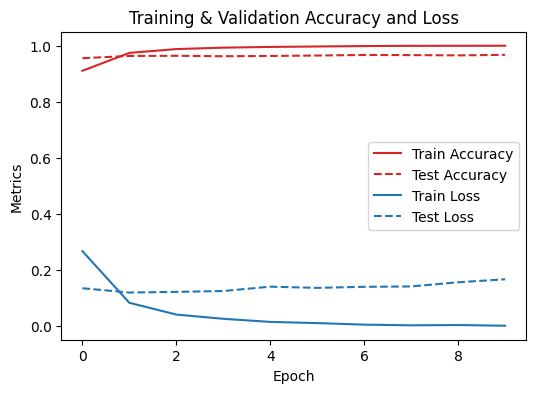

In [153]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

plt.plot(history.history['accuracy'], label='Train Accuracy', color='tab:red')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', color='tab:red', linestyle='dashed')

plt.plot(history.history['loss'], label='Train Loss', color='tab:blue')
plt.plot(history.history['val_loss'], label='Test Loss', color='tab:blue', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training & Validation Accuracy and Loss')
plt.legend()

plt.show()




In [154]:
from sklearn.metrics import confusion_matrix
def print_confusion_matrix(x,y,i):
    y_categorical = np.argmax(y, axis=1)
    pred = model.predict(x)
    pred_categorical = np.argmax(pred, axis=1)

    conf_matrix = confusion_matrix(y_categorical, pred_categorical)
    print("Confusion Matrix for Test Dataset " + str(i) + ":")
    print(conf_matrix)


In [155]:
print_confusion_matrix(X_test, y_test_encoded, 1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Confusion Matrix for Test Dataset 1:
[[  61    2   11    2    2]
 [   2   34    5    1   16]
 [   5    4   67    2    6]
 [   0    0    4  105    1]
 [   0    0    3    0 1666]]


In [156]:
print_confusion_matrix(X_test2, y_test2_encoded, 2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix for Test Dataset 2:
[[  73    2    6    0    2]
 [   2   18    4    0    6]
 [   5    6   74    1    7]
 [   0    1    3  129    4]
 [   2    2    3    0 1649]]


The multiclass classification model shows good results on the test data, achieving a high accuracy of 96.70% and an F1 score of 98.32%. 

